# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [60]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

from sklearn.metrics import confusion_matrix

from scipy import signal

In [61]:
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


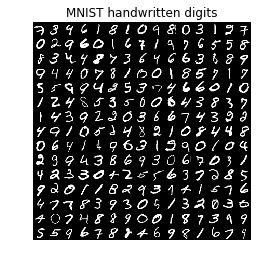

In [62]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)

## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [66]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


In [4]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
Flatten 	 (?, 3136)
denseOut	 (?, 10)
Model consits of  31786 trainable parameters.


In [5]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [6]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [8]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop


(<matplotlib.text.Text at 0x2308d5df7f0>,
 (0.75, 1.03))

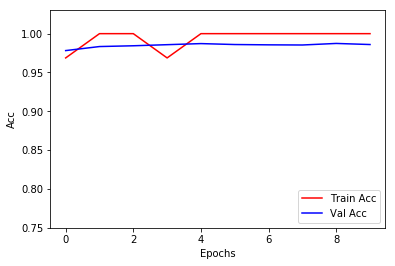

In [14]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

## Keras

In [68]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.optimizers import Adam

In [28]:
model = Sequential()
# input: (28, 28, 1)
# applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, nchannels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# softmax activation, one-hot encoded target with categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [29]:
history = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=32, epochs=10)

Epoch 1/10
55000/55000 [==============================] - 13s - loss: 0.1681 - acc: 0.9478    
Epoch 2/10
55000/55000 [==============================] - 12s - loss: 0.0587 - acc: 0.9820    
Epoch 3/10
55000/55000 [==============================] - 12s - loss: 0.0440 - acc: 0.9864    
Epoch 4/10
55000/55000 [==============================] - 12s - loss: 0.0349 - acc: 0.9893    
Epoch 5/10
55000/55000 [==============================] - 12s - loss: 0.0304 - acc: 0.9907    
Epoch 6/10
55000/55000 [==============================] - 12s - loss: 0.0253 - acc: 0.9921    
Epoch 7/10
55000/55000 [==============================] - 12s - loss: 0.0239 - acc: 0.9927    
Epoch 8/10
55000/55000 [==============================] - 12s - loss: 0.0206 - acc: 0.9941    
Epoch 9/10
55000/55000 [==============================] - 12s - loss: 0.0202 - acc: 0.9939    
Epoch 10/10
 9824/10000 [============================>.] - ETA: 0s

In [63]:
score, acc = model.evaluate(mnist_data.test.images, mnist_data.test.labels)

10000/10000 [==============================] - 0s     


In [64]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.0203816208113
Test accuracy: 0.9944


In [73]:
for i in range(0, 1000):
    res = model.predict(np.reshape(mnist_data.test.images[i], (1, 28, 28, 1)))
    if np.argmax(mnist_data.test.labels[i]) != np.argmax(res):
        print(i)

450
582
740
947


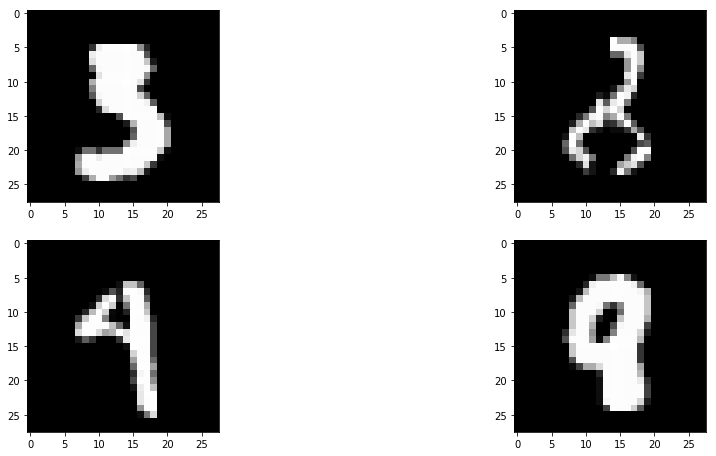

In [75]:
fig = plt.figure(figsize=(16,12))
image = mnist_data.test.images[450]
fig.add_subplot(321)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[582]
fig.add_subplot(322)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[740]
fig.add_subplot(323)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[947]
fig.add_subplot(324)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

In [74]:
for i in [450, 582, 740, 947]:
    res = model.predict(np.reshape(mnist_data.test.images[i], (1, 28, 28, 1)))
    print("Network output = {}. True output {}".format(np.argmax(res), np.argmax(mnist_data.test.labels[i])))

Network output = 5. True output 3
Network output = 2. True output 8
Network output = 9. True output 4
Network output = 9. True output 8


In [77]:
prediction = model.predict(np.reshape(mnist_data.test.images[740], (1, 28, 28, 1)))
print(prediction)

[[  3.79957896e-07   2.25197946e-05   4.21868572e-05   3.11141548e-06
    3.16704869e-01   2.60895922e-06   1.19775484e-06   1.43174641e-03
    5.81515837e-04   6.81209922e-01]]


# Assignments

## <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>





We just place the kernel matrix on top of the pixels and multiply, just as shown in the first notebook.

\begin{align}
    y_{0,0} &= 1 \cdot 2 +2 \cdot 3 = 8 \\
    y_{1,0} &= 2 \cdot 1 + 2 \cdot 1 + 2 \cdot 2 + 2 \cdot 3 = 14 \\
    y_{0,1} &= 2 \cdot 2 + 2 \cdot 2 + 3 \cdot 3 + 1 \cdot 1 + 2 \cdot 2 = 20 \\
    y_{1,1} &= 2 \cdot 2 + 2 \cdot 1 + 2 \cdot 2 + 3 \cdot 2 + 3 \cdot 3 = 25
\end{align}

We can verify the result with scipy

In [41]:
x = np.array([[0, 0, 0, 1],[0, 0,1,2],[0,0,2,3],[0,1,2,3]])
k=np.array([[0,0,2],[0,1,2],[0,2,3]])
k = np.rot90(k, 2)
y = signal.convolve2d(x, k, 'valid')

print(y)

[[ 8 20]
 [14 25]]



## <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

``` 
Paste your code here
```


``` 
Paste the trace of the tensors shape as it is propagated through the network here
```


In [ ]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 10
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 14
kernel_size_2 = (3,3)
pool_size_2 = (filters_2, filters_2)

#filters_3 = 16
#kernel_size_3 = (7,7)
#pool_size_3 = (12, 12)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
    x = flatten(x)
    print('Flatten \t', x.get_shape()) 
    
with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

In [ ]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
# Add saver op to restore the model for prediction  
saver = tf.train.Saver()

In [ ]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))
        
        saver.save(sess, './mnist_cnn')
        
    except KeyboardInterrupt:
        pass


In [ ]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_cnn')
    feed_dict_valid = {x_pl: mnist_data.test.images, y_pl: mnist_data.test.labels}

    # deciding which parts to fetch
    fetches_valid = [accuracy]          

    # running the validation
    test_acc = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
    
    y_pred = pred(mnist_data.test.images, sess)    # Get predictions
    
    y_pred_1 = np.zeros_like(y_pred) # Make new matrix to contain one-hot encoded values of y_pred
    y_pred_1[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # Sets max to 1 and everything else to 

In [ ]:
print('The test accuracy using elu is {}'.format(test_acc))

## <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>


In [50]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 10
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 14
kernel_size_2 = (3,3)
pool_size_2 = (filters_2, filters_2)

#filters_3 = 16
#kernel_size_3 = (7,7)
#pool_size_3 = (12, 12)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    
    x = flatten(x)
    print('Flatten \t', x.get_shape()) 
    
with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 10)
pool1 		 (?, 14, 14, 10)
conv2 		 (?, 14, 14, 14)
pool2 		 (?, 1, 1, 14)
Flatten 	 (?, 14)
denseOut	 (?, 10)
Model consits of  1684 trainable parameters.


In [51]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
# Add saver op to restore the model for prediction  
saver = tf.train.Saver()

In [53]:
#Training Loop
batch_size = 100
max_epochs = 10

valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))
        
        saver.save(sess, './mnist_cnn')
        
    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 0 : Train Loss  2.314, Train acc  0.090,  Valid loss  2.314,  Valid acc  0.099
Epoch 1 : Train Loss  0.642, Train acc  0.820,  Valid loss  0.569,  Valid acc  0.829
Epoch 2 : Train Loss  0.455, Train acc  0.850,  Valid loss  0.365,  Valid acc  0.887
Epoch 3 : Train Loss  0.487, Train acc  0.880,  Valid loss  0.296,  Valid acc  0.910
Epoch 4 : Train Loss  0.283, Train acc  0.920,  Valid loss  0.266,  Valid acc  0.919
Epoch 5 : Train Loss  0.272, Train acc  0.910,  Valid loss  0.243,  Valid acc  0.922
Epoch 6 : Train Loss  0.391, Train acc  0.870,  Valid loss  0.219,  Valid acc  0.932
Epoch 7 : Train Loss  0.261, Train acc  0.900,  Valid loss  0.215,  Valid acc  0.935
Epoch 8 : Train Loss  0.195, Train acc  0.930,  Valid loss  0.193,  Valid acc  0.941
Epoch 9 : Train Loss  0.338, Train acc  0.900,  Valid loss  0.185,  Valid acc  0.941
Epoch 10 : Train Loss  0.190, Train acc  0.950,  Valid loss  0.181,  Valid acc  0.944
Test Loss  0.176, Test acc  0.947


(<matplotlib.text.Text at 0x7f45def43f60>,
 (0.75, 1.03))

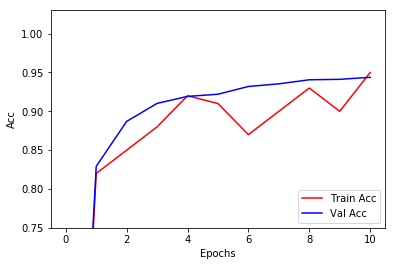

In [54]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

In [28]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

In [29]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_cnn')
    feed_dict_valid = {x_pl: mnist_data.test.images, y_pl: mnist_data.test.labels}

    # deciding which parts to fetch
    fetches_valid = [accuracy]          

    # running the validation
    test_acc = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
    
    y_pred = pred(mnist_data.test.images, sess)    # Get predictions
    
    y_pred_1 = np.zeros_like(y_pred) # Make new matrix to contain one-hot encoded values of y_pred
    y_pred_1[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # Sets max to 1 and everything else to 0.

INFO:tensorflow:Restoring parameters from ./mnist_cnn


In [33]:
print(confusion_matrix(mnist_data.test.labels.argmax(1), y_pred_1.argmax(1))) 

[[ 962    0    2    1    1    2    9    3    0    0]
 [   0 1127    3    0    0    0    0    3    2    0]
 [   5    1 1017    1    2    0    0    4    2    0]
 [   0    0    1  996    0   10    0    3    0    0]
 [   0    0    1    0  967    1    3    1    1    8]
 [   2    0    0    4    0  883    2    1    0    0]
 [   3    2    1    0    3    8  941    0    0    0]
 [   0    2    9    0    1    0    0 1013    1    2]
 [   4    1    1    9    3   11    2    3  936    4]
 [   3    1    3    2    6    5    1   11    2  975]]


In [30]:
print('The test accuracy using elu is {}'.format(test_acc))

The test accuracy using elu is [0.9817]


## <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>


In [64]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )

num_features = mnist_data.train.images[0].shape[0]

num_classes = mnist_data.train.labels[0].shape[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [90]:
n_hidden1 = 2

model = Sequential()

model.add(Dense(n_hidden1, activation='elu', input_dim=num_features))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

print('Parameters {}'.format(model.count_params()))

Parameters 1600


In [91]:
epochs = 10
batch_size = 100

for e in range(epochs):
    train_loss = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=batch_size, nb_epoch=1, verbose = 0)
    val_score, val_acc = model.evaluate(mnist_data.validation.images, mnist_data.validation.labels, batch_size=batch_size, verbose = 0)
    
    print(val_acc)

/home/andreas/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.442999998927
0.501199997067
0.575799996853
0.577799995542
0.621999996901
0.61059999764
0.620199999809
0.62259999752
0.644200003147
0.689200005531


In [92]:
score, acc = model.evaluate(mnist_data.test.images, mnist_data.test.labels)

 9824/10000 [============================>.] - ETA: 0s

In [93]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.07810771227
Test accuracy: 0.6706


 Or just train

In [95]:
history = model.fit(mnist_data.train.images, mnist_data.train.labels, batch_size=100, epochs=10)

Epoch 1/10
55000/55000 [==============================] - 1s - loss: 0.9626 - acc: 0.7161     
Epoch 2/10
55000/55000 [==============================] - 1s - loss: 0.9603 - acc: 0.7161     
Epoch 3/10
55000/55000 [==============================] - 1s - loss: 0.9579 - acc: 0.7177     
Epoch 4/10
55000/55000 [==============================] - 1s - loss: 0.9563 - acc: 0.7171     
Epoch 5/10
55000/55000 [==============================] - 1s - loss: 0.9549 - acc: 0.7179     
Epoch 6/10
55000/55000 [==============================] - 1s - loss: 0.9524 - acc: 0.7181     
Epoch 7/10
55000/55000 [==============================] - 1s - loss: 0.9513 - acc: 0.7191     
Epoch 8/10
55000/55000 [==============================] - 1s - loss: 0.9500 - acc: 0.7196     
Epoch 9/10
55000/55000 [==============================] - 1s - loss: 0.9476 - acc: 0.7194     
Epoch 10/10
55000/55000 [==============================] - 1s - loss: 0.9477 - acc: 0.7202     
